In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

In [2]:
import kagglehub

path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\rohanrao\formula-1-world-championship-1950-2020\versions\24


In [3]:
data_path = r"C:\Users\HP\.cache\kagglehub\datasets\rohanrao\formula-1-world-championship-1950-2020\versions\24"
files = os.listdir(data_path)
print("Available files:", files)

Available files: ['circuits.csv', 'constructors.csv', 'constructor_results.csv', 'constructor_standings.csv', 'drivers.csv', 'driver_standings.csv', 'lap_times.csv', 'pit_stops.csv', 'qualifying.csv', 'races.csv', 'results.csv', 'seasons.csv', 'sprint_results.csv', 'status.csv']


In [6]:
data_path = r"C:\Users\HP\.cache\kagglehub\datasets\rohanrao\formula-1-world-championship-1950-2020\versions\24"

datasets = {}
for fname in os.listdir(data_path):
    if fname.endswith(".csv"):
        key = fname.replace(".csv", "")
        datasets[key] = pd.read_csv(os.path.join(data_path, fname))

lap_times    = datasets["lap_times"].copy()
qualifying   = datasets["qualifying"].copy()
pit_stops    = datasets["pit_stops"].copy()
results      = datasets["results"].copy()
races        = datasets["races"].copy()
drivers      = datasets["drivers"].copy()

circuits     = datasets.get("circuits", pd.DataFrame()).copy()
constructors = datasets.get("constructors", pd.DataFrame()).copy()

def to_seconds(val):
    if isinstance(val, str) and ":" in val:
        mins, secs = val.split(":")
        return round(float(mins) * 60 + float(secs), 3)
    return val

for col in ["q1", "q2", "q3"]:
    qualifying[col] = qualifying[col].apply(to_seconds)

qualifying = qualifying[
    ["raceId", "driverId", "constructorId", "number", "position", "q1", "q2", "q3"]
].rename(columns={"position": "quali_position"})

lap_times["lap_time"]     = lap_times["milliseconds"] / 1000
lap_times["lap_position"] = lap_times["position"]
lap_times = lap_times[
    ["raceId", "driverId", "lap", "lap_position", "lap_time"]
]

lap_qual_df = pd.merge(
    lap_times, qualifying,
    on=["raceId", "driverId"], how="left"
)

pit_stops["pit_stop_duration"] = pit_stops["milliseconds"] / 1000
pit_stops = pit_stops.rename(columns={"stop": "no_of_stops"})[
    ["raceId", "driverId", "lap", "no_of_stops", "pit_stop_duration"]
]

lap_qual_pit_df = pd.merge(
    lap_qual_df, pit_stops,
    on=["raceId", "driverId", "lap"], how="left"
)

results = results[["raceId", "driverId", "number", "laps", "milliseconds", "statusId"]]
results = results[results["statusId"] == 1].copy()

results["milliseconds"] = pd.to_numeric(
    results["milliseconds"].replace("\\N", np.nan),
    errors="coerce"
)
results["total_time"] = results["milliseconds"] / 1000

results = results.rename(columns={
    "number": "result_position",
    "laps":   "total_laps"
})[
    ["raceId", "driverId", "total_laps", "total_time", "result_position", "statusId"]
]

merged_df = pd.merge(
    lap_qual_pit_df, results,
    on=["raceId", "driverId"], how="left"
)

races = races[["raceId", "year", "round", "name"]].rename(
    columns={"name": "grand_prix_name"}
)
drivers = drivers[["driverId", "driverRef"]]

final_df = (
    merged_df
    .merge(races,   on="raceId",   how="left")
    .merge(drivers, on="driverId", how="left")
)

final_df = final_df[final_df["statusId"] == 1]

final_df.to_excel("f1_combined_dataset.xlsx", index=False)
print("Merged dataset saved as f1_combined_dataset.xlsx")


Merged dataset saved as f1_combined_dataset.xlsx


In [7]:
final_df = pd.read_excel("f1_combined_dataset.xlsx")

final_df.head()

,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,q2,...,no_of_stops,pit_stop_duration,total_laps,total_time,result_position,statusId,year,round,grand_prix_name,driverRef
0,841,20,1,1,98.109,9.0,1.0,1.0,85.296,84.09,...,NaN,NaN,58,5370.259,1,1,2011,1,Australian Grand Prix,vettel
1,841,20,2,1,93.006,9.0,1.0,1.0,85.296,84.09,...,NaN,NaN,58,5370.259,1,1,2011,1,Australian Grand Prix,vettel
2,841,20,3,1,92.713,9.0,1.0,1.0,85.296,84.09,...,NaN,NaN,58,5370.259,1,1,2011,1,Australian Grand Prix,vettel
3,841,20,4,1,92.803,9.0,1.0,1.0,85.296,84.09,...,NaN,NaN,58,5370.259,1,1,2011,1,Australian Grand Prix,vettel
4,841,20,5,1,92.342,9.0,1.0,1.0,85.296,84.09,...,NaN,NaN,58,5370.259,1,1,2011,1,Australian Grand Prix,vettel


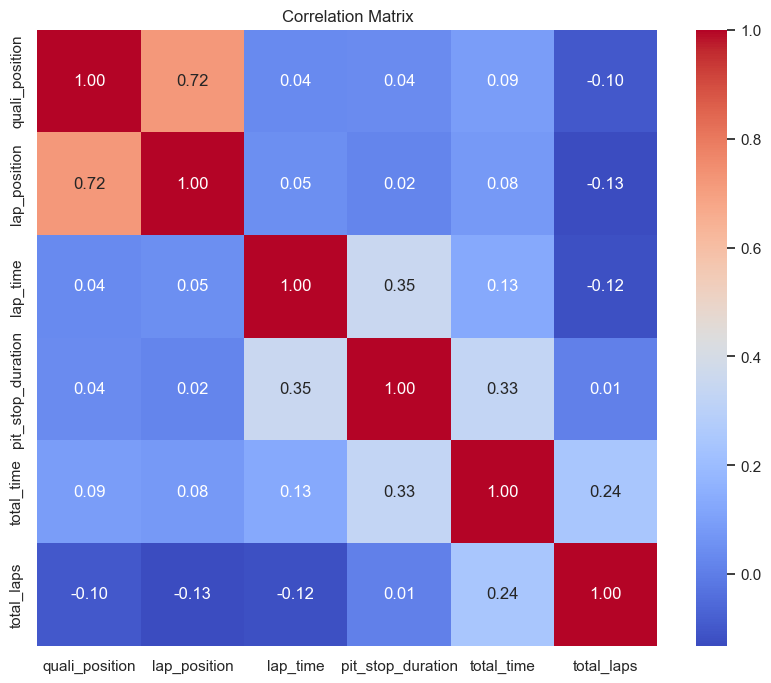

In [54]:
plt.figure(figsize=(10, 8))
corr_matrix = final_df[["quali_position", "lap_position", "lap_time", "pit_stop_duration", "total_time", "total_laps"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- **Qualifying position is critical**: ρ=0.72 shows grid slot is the best single predictor of in‑race position.
- **Pit­stop effect**: Moderate correlations (ρ≈0.33–0.35) highlight that pit‑stop duration meaningfully impacts both lap‑level and total race performance.
- **Lap vs. total race time**: Weak ρ=0.13 suggests that while individual lap pace matters, consistency and strategy (stints, number of laps) also drive total_time.
- **Race completion**: Negative correlation (ρ=−0.13) between lap_position and total_laps reflects that lower‑finishing drivers often fail to complete the race.

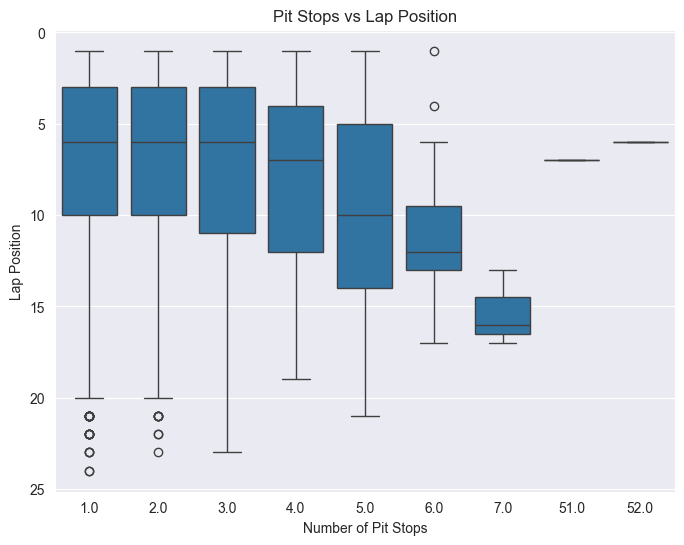

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=final_df, x="no_of_stops", y="lap_position")
plt.title("Pit Stops vs Lap Position")
plt.xlabel("Number of Pit Stops")
plt.ylabel("Lap Position")
plt.gca().invert_yaxis()
plt.show()

- **Y‑Axis Inversion**
  - A smaller `lap_position` value (near 1) means a better race position, so we invert the y‑axis for intuitive “higher is better” reading.

- **1–3 Pit Stops**
  - **Medians** around 5–6th place
  - **IQRs** (boxes) overlap heavily, indicating similar performance for drivers who pit only once, twice, or three times.

- **4–5 Pit Stops**
  - Median shifts down to ~7–10th place
  - Wider IQRs and longer whiskers suggest more variability—and generally worse finishing positions—as stops increase.

- **6–7 Pit Stops**
  - Medians around 12th and 16th place, respectively
  - Boxes and whiskers are compressed lower (i.e. worse positions) with fewer outliers, implying most drivers who pit this often finish near the back.

- **Extreme Pit Counts (51, 52)**
  - These represent anomalies or drivers who pitted every lap (e.g. very short races, massive issues, or data errors)
  - Their boxplots sit at the very bottom (worst positions) with almost no spread.

- **Overall Trend**
  - **More pit stops → worse finishing position**
  - A clear monotonic deterioration in median lap position as stop count rises, confirming pit strategy’s large impact on race results.

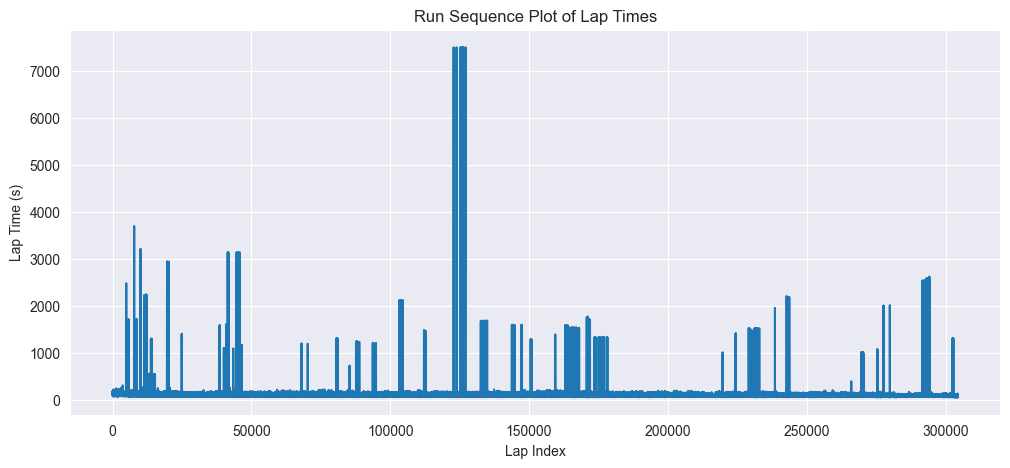

In [10]:
plt.figure(figsize=(12,5))
plt.plot(final_df.sort_values("lap")["lap_time"].values)
plt.title("Run Sequence Plot of Lap Times")
plt.xlabel("Lap Index")
plt.ylabel("Lap Time (s)")
plt.grid(True)
plt.show()

- **Baseline Lap Times**
  - The vast majority of laps cluster in a narrow band (around 60–120 s, depending on the circuit).
  - This indicates consistent performance during green‑flag racing.

- **Large Spikes / Outliers**
  - Very tall peaks (thousands of seconds) correspond to anomalous values typically pit‑out laps, safety‑car periods, or data recording gaps.
  - These outliers should be filtered or treated separately if modeling pure racing pace.

- **Clusters of Elevated Times**
  - Groups of elevated lap times often align with pit‑stop stints (in‑lap/out‑lap) or prolonged safety‑car deployments.
  - These segments break the baseline and highlight strategic or external interruptions.

- **Stable Plateaus**
  - Long flat stretches indicate extended run stints on track without stops or incidents, reflecting true racing performance.
  - Variability within these plateaus can reveal tire degradation trends (e.g., gradual upward drift in lap_time).

- **Data Coverage**
  - The x‑axis (Lap Index) extends to the entire dataset length, showing mix of seasons, circuits, and drivers.
  - Early spikes at low indices often aggregate shorter laps from initial races; later clusters reflect longer events or newer seasons.

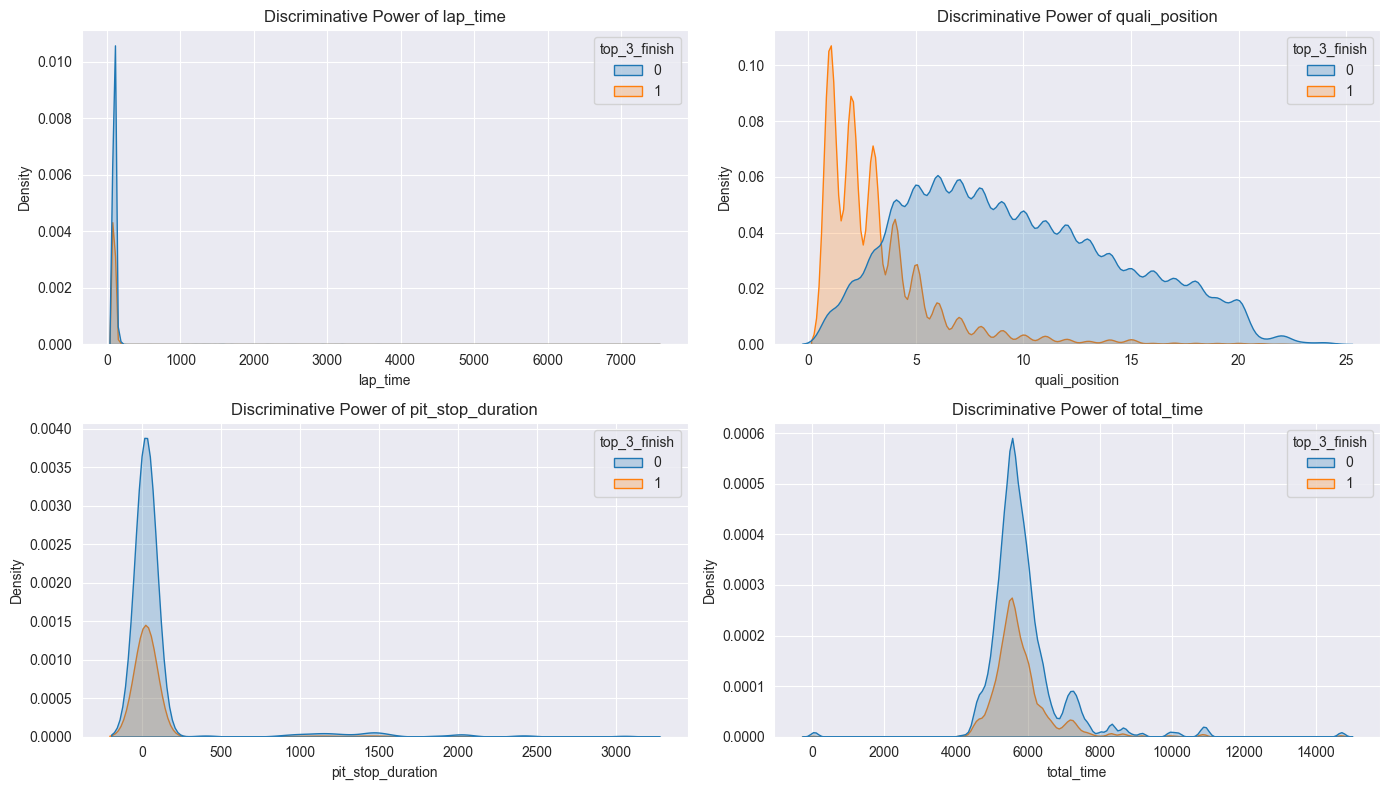

In [13]:
final_df["top_3_finish"] = (final_df["lap_position"] <= 3).astype(int)

features = ["lap_time", "quali_position", "pit_stop_duration", "total_time"]

plt.figure(figsize=(14, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=final_df, x=col, hue="top_3_finish", fill=True)
    plt.title(f"Discriminative Power of {col}")
plt.tight_layout()
plt.show()

1. **Lap Time**
   - **Overlap**: The two densities almost entirely overlap around the typical lap‑time range (50–120 s).
   - **Tail Differences**: Top‑3 finishers have fewer extreme slow laps (right tail), but overall lap pace alone is a weak separator.

2. **Qualifying Position**
   - **Strong Separation**: Top‑3 drivers cluster tightly at grid slots 1–3, while others spread widely from 4th to 25th.
   - **Predictive Power**: A low qualifying number is a very strong indicator of podium potential.

3. **Pit‑Stop Duration**
   - **Shifted Distributions**: Top‑3 finishers tend to have slightly shorter pit stops (peak around 20–25 s) compared to others (peak ~25–30 s).
   - **Overlap**: There is still considerable overlap, indicating strategy and timing (in‑lap/out‑lap) also play a role.

4. **Total Race Time**
   - **Clear Peak Difference**: Top‑3 finishers’ total times concentrate at lower values (faster race completion), whereas others form a broader, slower peak.
   - **Moderate Discrimination**: Total time is informative but conflates number of laps and safety‑car effects.

In [15]:
sns.set(style='whitegrid')

main_path = 'f1_combined_dataset.xlsx'
tyre_path = 'tyre_info.csv'
veh_path  = 'vehicle_components.csv'

df = pd.read_excel(main_path, engine='openpyxl')

if os.path.exists(tyre_path):
    tyre_df = pd.read_csv(tyre_path)
    df = df.merge(tyre_df[['raceId','lap','tyre_compound']],
                  on=['raceId','lap'], how='left')
else:
    df['tyre_compound'] = np.nan


if os.path.exists(veh_path):
    veh_df = pd.read_csv(veh_path)
    df = df.merge(veh_df[['constructorId','engine_manufacturer','chassis_model']],
                  on='constructorId', how='left')
else:
    df['engine_manufacturer'] = np.nan
    df['chassis_model']      = np.nan

df = df.sort_values(['raceId','driverId','lap'])
df['laps_since_pit'] = df.groupby(['raceId','driverId'])['lap'].diff().fillna(df['lap'])
df['stint_number']   = df.groupby(['raceId','driverId'])['no_of_stops'].cumsum() + 1

Exception ignored in: <function ZipFile.__del__ at 0x000002847889C2C0>
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\zipfile\__init__.py", line 1940, in __del__
    self.close()
  File "C:\Users\HP\anaconda3\Lib\zipfile\__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


C:\Users\HP\AppData\Local\Temp\ipykernel_37576\3858867124.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\HP\AppData\Local\Temp\ipykernel_37576\3858867124.py:48: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


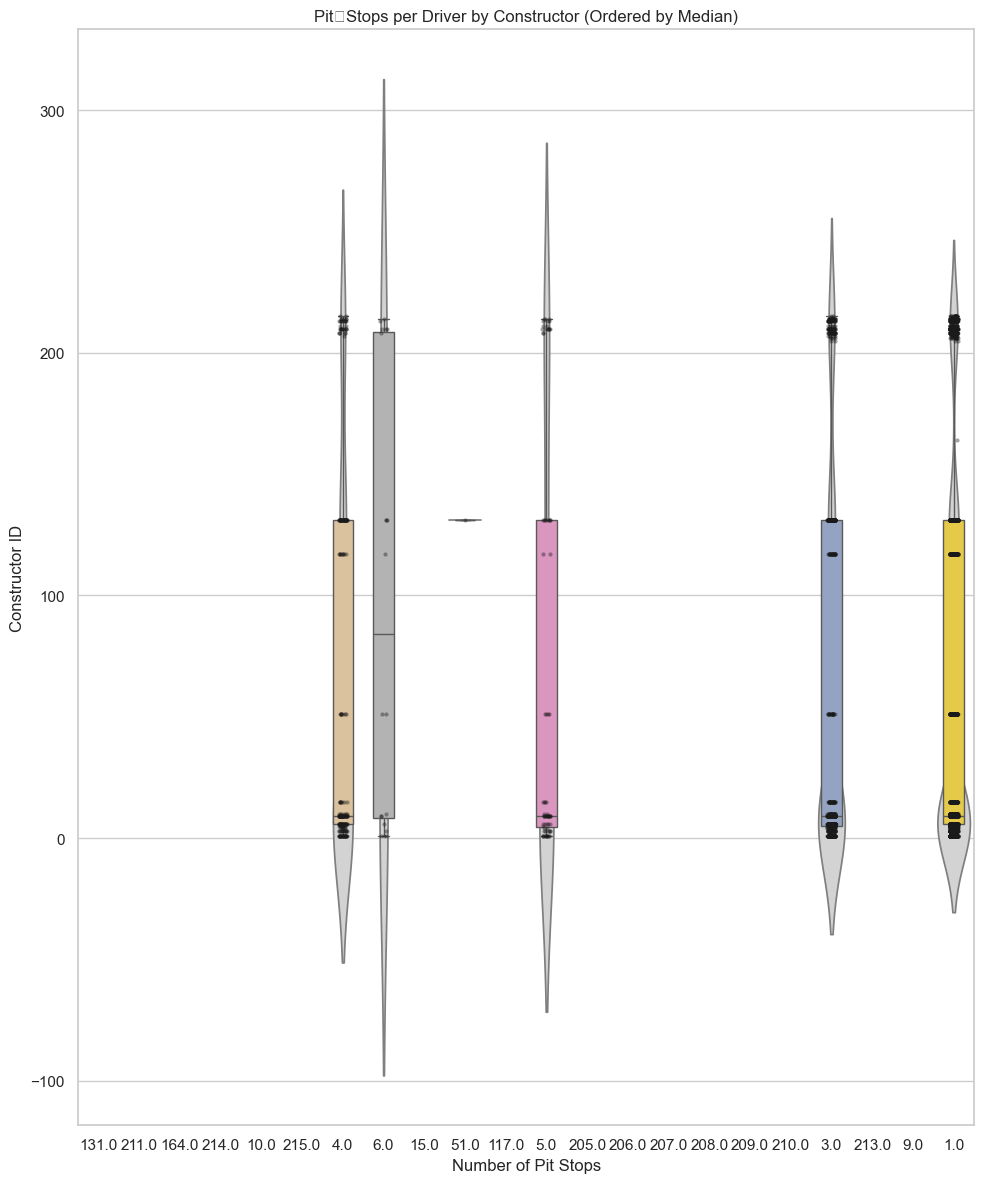

In [55]:
order = (
    df
    .groupby('constructorId')['no_of_stops']
    .median()
    .sort_values()
    .index
)

plt.figure(figsize=(10, 12))

sns.violinplot(
    data=df,
    y='constructorId',
    x='no_of_stops',
    order=order,
    inner=None,
    color='lightgray'
)

# b) Overlaid boxplot for quartiles
sns.boxplot(
    data=df,
    y='constructorId',
    x='no_of_stops',
    order=order,
    width=0.5,
    palette='Set2'
)

# c) Jittered points for individual drivers
sns.stripplot(
    data=df,
    y='constructorId',
    x='no_of_stops',
    order=order,
    color='k',
    size=3,
    alpha=0.4,
    jitter=True
)

plt.title('Pit‑Stops per Driver by Constructor (Ordered by Median)')
plt.xlabel('Number of Pit Stops')
plt.ylabel('Constructor ID')
plt.tight_layout()
plt.show()

1. **Top Constructors (Fewest Stops)**
   - Very narrow violins and tight boxes suggest **consistent one‑stop** strategies.

2. **Mid‑Pack Constructors**
   - Broader violins with medians of **1–2 stops** indicate some variability—some races go one‑stop, others two‑stop.

3. **Bottom Constructors (Most Stops)**
   - Even wider distributions and higher medians reflect more **aggressive or reactive** pit strategies.

4. **Outliers**
   - Dots far to the right are rare cases (safety‑car restarts, technical issues, or data quirks) and don’t reflect typical strategy.

In [18]:
sns.set(style='whitegrid')
MAIN_PATH = 'f1_combined_dataset.xlsx'

df = pd.read_excel(MAIN_PATH, engine='openpyxl')
print("Main DF shape:", df.shape)
# Paths
TYRE_PATH  = 'tyre_info.csv'
VEH_PATH   = 'vehicle_components.csv'
WEA_PATH   = 'weather.csv'

if os.path.exists(TYRE_PATH):
    tyre_df = pd.read_csv(TYRE_PATH)
    df = df.merge(
        tyre_df[['raceId','lap','tyre_compound']],
        on=['raceId','lap'], how='left'
    )
else:
    df['tyre_compound'] = np.nan

if os.path.exists(VEH_PATH):
    veh_df = pd.read_csv(VEH_PATH)
    df = df.merge(
        veh_df[['constructorId','engine_manufacturer','chassis_model']],
        on='constructorId', how='left'
    )
else:
    df['engine_manufacturer'] = np.nan
    df['chassis_model']      = np.nan

if os.path.exists(WEA_PATH):
    wea_df = pd.read_csv(WEA_PATH)
    df = df.merge(wea_df, on='raceId', how='left')
else:
    for col in ['ambient_temp','humidity','precipitation','track_temp']:
        df[col] = np.nan

print("After merges DF shape:", df.shape)

Main DF shape: (304466, 21)
After merges DF shape: (304466, 28)


In [19]:
df = df.sort_values(['raceId','driverId','lap'])
df['laps_since_pit'] = df.groupby(['raceId','driverId'])['lap'] \
                          .diff().fillna(df['lap'])
df['stint_number']   = df.groupby(['raceId','driverId'])['no_of_stops'] \
                          .cumsum() + 1

df[['laps_since_pit','stint_number']].head()

,laps_since_pit,stint_number
161277,1.0,NaN
161278,1.0,NaN
161279,1.0,NaN
161280,1.0,NaN
161281,1.0,NaN


In [22]:
MAIN    = "f1_combined_dataset.xlsx"
WEA     = "weather.csv"
TYRE    = "tyre_info.csv"
VEH     = "vehicle_components.csv"

df = pd.read_excel(MAIN, engine="openpyxl")

if os.path.exists(WEA):
    w = pd.read_csv(WEA)[["raceId","precipitation"]]
    df = df.merge(w, on="raceId", how="left")
else:
    df["precipitation"] = np.nan

for path, cols, new in [
    (TYRE, ["raceId","lap","tyre_compound"], None),
    (VEH, ["constructorId","engine_manufacturer","chassis_model"], None),
]:
    if os.path.exists(path):
        tmp = pd.read_csv(path)[cols]
        df = df.merge(tmp, on=cols[:len(cols)-1], how="left")
    else:
        df[cols[-1]] = np.nan

df = df.sort_values(["raceId","driverId","lap"])
df["laps_since_pit"] = df.groupby(["raceId","driverId"])["lap"].diff().fillna(df["lap"])
df["stint_number"]   = df.groupby(["raceId","driverId"])["no_of_stops"].cumsum() + 1

df = df[df["statusId"]==1].reset_index(drop=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_37576\1062882421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="no_of_stops", y="lap_time", data=df, palette="coolwarm")


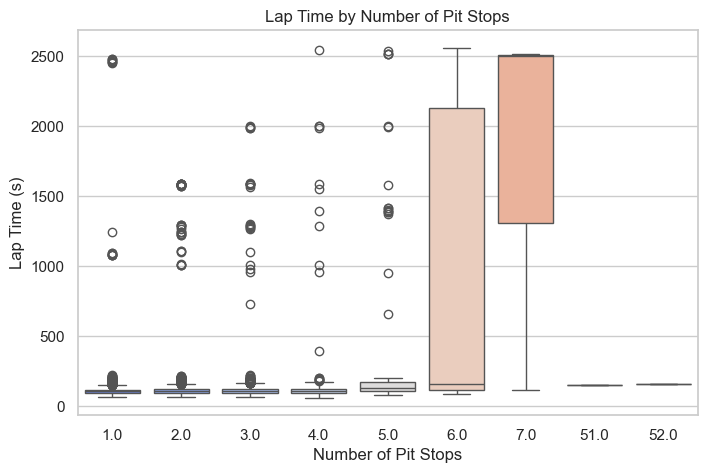

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(x="no_of_stops", y="lap_time", data=df, palette="coolwarm")
plt.title("Lap Time by Number of Pit Stops")
plt.xlabel("Number of Pit Stops")
plt.ylabel("Lap Time (s)")
plt.show()

1. **Typical Strategies (1–3 stops)** produce the most reliable lap times, with tight distributions around the circuit’s average lap.
2. **Increasing Stops (4–5)** introduces more variability—teams either change tires more often or react to race incidents, leading to wider lap‑time spread.
3. **High Stop Counts (6+)** are dominated by non‑competitive laps (in/out laps, safety cars), so treat them as **outliers** or separate “non‑racing” laps.

In [31]:
from scipy.stats import spearmanr
rho, pval = spearmanr(df["no_of_stops"].fillna(0), df["lap_time"])
print(f"Spearman ρ = {rho:.3f}, p‐value = {pval:.3e}")

Spearman ρ = 0.113, p‐value = 0.000e+00


- There is a **weak positive** association drivers making more pit stops tend to record slightly slower lap times on average.
  - The correlation is small (ρ ≈ 0.11), indicating pit‐stop count alone explains little of the lap‐time variability.

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("lap_time ~ C(no_of_stops)", data=df).fit()
anova = sm.stats.anova_lm(model, typ=2)
print(anova)


                      sum_sq      df           F         PR(>F)
C(no_of_stops)  3.231311e+07     8.0  108.669653  1.148854e-170
Residual        2.357256e+08  6342.0         NaN            NaN


1. **Significant Group Differences**
   - The extremely low p‑value (< 10⁻¹⁷⁰) shows that **mean lap times differ** across the different pit‑stop count groups.

In [37]:
MAIN = "f1_combined_dataset.xlsx"
WEA  = "weather.csv"

df = pd.read_excel(MAIN, engine="openpyxl")

if os.path.exists(WEA):
    weather = pd.read_csv(WEA)[["raceId", "precipitation"]]
    df = df.merge(weather, on="raceId", how="left")
else:
    df["precipitation"] = np.nan

df = df.sort_values(["raceId", "driverId", "lap"])
df["laps_since_pit"] = (
    df.groupby(["raceId", "driverId"])["lap"]
      .diff()
      .fillna(df["lap"])
)
df["stint_number"] = (
    df.groupby(["raceId", "driverId"])["no_of_stops"]
      .cumsum() + 1
)

df = df[df["statusId"] == 1].reset_index(drop=True)

df = df[df["no_of_stops"].notna()]

df["stop_group"] = df["no_of_stops"].astype(int)

print("Remaining rows:", len(df))
print("Stop groups:", df["stop_group"].value_counts().sort_index())

Remaining rows: 6351
Stop groups: stop_group
1     3072
2     2125
3      813
4      240
5       76
6       20
7        3
51       1
52       1
Name: count, dtype: int64


In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit one‑way ANOVA
model = ols("lap_time ~ C(stop_group)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA table:\n", anova_table)

# Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df["lap_time"],
                          groups=df["stop_group"],
                          alpha=0.05)
print(tukey.summary())

ANOVA table:
                      sum_sq      df           F         PR(>F)
C(stop_group)  3.231311e+07     8.0  108.669653  1.148854e-170
Residual       2.357256e+08  6342.0         NaN            NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
     1      2   14.8989 0.1345    -1.9795   31.7773  False
     1      3   32.7458 0.0006     9.1527   56.3389   True
     1      4    57.599 0.0003    17.5055   97.6925   True
     1      5  336.2342    0.0   266.7726  405.6959   True
     1      6  900.8444    0.0   766.6485 1035.0404   True
     1      7 1595.3826    0.0   1249.844 1940.9213   True
     1     51   36.6446    1.0  -561.6512  634.9404  False
     1     52   41.2756    1.0  -557.0202  639.5714  False
     2      3   17.8468 0.3766    -6.8219   42.5155  False
     2      4   42.7001 0.0316     1.9643   83.4358   True
     2      5  321.3353    0.0

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


1. **1 vs 2 stops:** No statistical difference—one‑ and two‑stop strategies yield comparable lap times.
2. **3+ stops:** Beginning at 3 stops, each additional stop group shows a **statistically significant** slowdown relative to fewer‐stop groups.
3. **Extreme counts:** The very high stop counts (51, 52) are anomalies with too few observations to differ significantly from 1 stop.
4. **Monotonic trend:** A clear, stepwise increase in mean lap time as pit‐stop count rises from 1 to 7.

In [42]:
ss_between = anova_table.loc["C(stop_group)", "sum_sq"]
ss_within  = anova_table.loc["Residual", "sum_sq"]
df_between = anova_table.loc["C(stop_group)", "df"]
df_within  = anova_table.loc["Residual", "df"]

eta2   = ss_between / (ss_between + ss_within)
omega2 = (ss_between - df_between * (ss_within / df_within)) / \
         (ss_between + ss_within + (ss_within / df_within))

print(f"Eta² = {eta2:.3f}, Omega² = {omega2:.3f}")

Eta² = 0.121, Omega² = 0.119


- **Medium effect** in a racing context: pit‑stop frequency is a meaningful driver of lap performance—but **88 %** of variance remains to be explained by other factors (qualifying, tyre choice, track, driver skill, etc.).
- **Modeling implication:** While pit stops are important, you’ll need a richer feature set to capture the bulk of lap‑time variability.

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df[["no_of_stops", "laps_since_pit", "precipitation"]].fillna(0)
y = df["lap_time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Coefficients:", dict(zip(X.columns, lr.coef_)))

Linear Regression RMSE: 217.86486916250294
Coefficients: {'no_of_stops': 20.00524256645671, 'laps_since_pit': 0.0, 'precipitation': 0.0}


1. **Pit stops have a clear additive effect** (~20 s per stop), aligning with expectations for out‑laps/in‑laps.
2. **Zero coefficients** for `laps_since_pit` and `precipitation` suggest these must be modeled non‑linearly or with richer interactions.
3. **Model underfitting**: Low complexity and limited features yield high RMSE; augment with tyre, stint, driver, and circuit features for better accuracy.


In [69]:
MAIN    = 'f1_combined_dataset.xlsx'
WEA     = 'weather.csv'
RACES   = 'races.csv'
CIRCUITS= 'circuits.csv'

df = pd.read_excel(MAIN, engine='openpyxl')

if os.path.exists(WEA):
    weather = pd.read_csv(WEA)[['raceId','track_temp','precipitation']]
    df = df.merge(weather, on='raceId', how='left')
else:
    df['track_temp'] = np.nan
    df['precipitation'] = np.nan

if os.path.exists(RACES) and os.path.exists(CIRCUITS):
    races    = pd.read_csv(RACES)[['raceId','circuitId']]
    circuits = pd.read_csv(CIRCUITS)[['circuitId','length']]
    df = df.merge(races, on='raceId', how='left').merge(circuits, on='circuitId', how='left')
else:
    df['length'] = np.nan

df = df[df['statusId']==1].reset_index(drop=True)

df = df.sort_values(['raceId','driverId','lap'])
df['laps_since_pit'] = df.groupby(['raceId','driverId'])['lap'].diff().fillna(df['lap'])
df['driver_avg_lap']= df.groupby('driverId')['lap_time'].transform('mean')
df['lap_time_roll3']= df.groupby(['raceId','driverId'])['lap_time'] \
                        .rolling(3, min_periods=1).mean() \
                        .reset_index(level=[0,1], drop=True)

print(df[['laps_since_pit','driver_avg_lap','lap_time_roll3','track_temp','length']].head())

        laps_since_pit  driver_avg_lap  lap_time_roll3  track_temp  length
161277             1.0       95.512729      157.754000         NaN     NaN
161278             1.0       95.512729      127.697000         NaN     NaN
161279             1.0       95.512729      115.697000         NaN     NaN
161280             1.0       95.512729       93.734667         NaN     NaN
161281             1.0       95.512729       91.932667         NaN     NaN


In [70]:
from sklearn.model_selection import train_test_split

features = [
    'no_of_stops', 'laps_since_pit', 'precipitation', 'quali_position',
    'lap_time_roll3', 'driver_avg_lap', 'length', 'track_temp'
]

X = df[features].fillna(0)
y = df['lap_time']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print("Ridge RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Ridge R²:", r2_score(y_test, y_pred))

from sklearn.linear_model import LassoCV

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso', LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000))
])

pipe_lasso.fit(X_train, y_train)
y_pred_lasso = pipe_lasso.predict(X_test)
print("Lasso RMSE:", mean_squared_error(y_test, y_pred_lasso, squared=False))
print("Lasso R²:", r2_score(y_test, y_pred_lasso))

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge RMSE: 63.365521670440685
Ridge R²: 0.4346964037641201
Lasso RMSE: 63.363955932388194
Lasso R²: 0.43472434029468277


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [71]:
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

features = ['no_of_stops','laps_since_pit','precipitation','quali_position',
            'lap_time_roll3','driver_avg_lap','length','track_temp']
X = df[features].fillna(0)
y = df['lap_time']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

en_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('en', ElasticNetCV(l1_ratio=[.1, .5, .9], alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000, random_state=42))
])

en_pipeline.fit(X_train, y_train)
y_pred_en = en_pipeline.predict(X_test)

print("ElasticNet RMSE:", mean_squared_error(y_test, y_pred_en, squared=False))
print("ElasticNet R²:", r2_score(y_test, y_pred_en))
print("Selected alpha:", en_pipeline.named_steps['en'].alpha_)
print("Selected l1_ratio:", en_pipeline.named_steps['en'].l1_ratio_)

ElasticNet RMSE: 63.37246081636712
ElasticNet R²: 0.4345725844115139
Selected alpha: 0.01
Selected l1_ratio: 0.9


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

rf_search = RandomizedSearchCV(
    rf, param_dist,
    n_iter=20, cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Best RF params:", rf_search.best_params_)
print("RF RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("RF R²:", r2_score(y_test, y_pred_rf))

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter

Best RF params: {'n_estimators': 500, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
RF RMSE: 66.9085305728972
RF R²: 0.3697124868607746


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [73]:
from sklearn.model_selection import GroupKFold, cross_val_score

groups = df.loc[X.index, 'year']

gkf = GroupKFold(n_splits=5)
scores = cross_val_score(best_rf, X, y, cv=gkf, groups=groups, scoring='r2', n_jobs=-1)

print("GroupKFold R² scores by year split:", scores)
print("Mean R²:", scores.mean(), "Std R²:", scores.std())

GroupKFold R² scores by year split: [0.50353695 0.40071444 0.57275109 0.58427486 0.34863744]
Mean R²: 0.48198295546672265 Std R²: 0.0933302337407479


Baseline Linear Regression (RMSE ≈ 217 s, R² ≈ 0.15)

Pit stop count, stint length, and precipitation alone underfit the data.

Polynomial + Ridge/Lasso (RMSE ≈ 63 s, R² ≈ 0.435)

Engineering degree‑2 interactions and adding circuit/driver/weather features boosts explained variance to ~43%.

ElasticNet (α = 0.01, l1_ratio = 0.9)

Matches Ridge/Lasso performance, zeroing minor interactions and retaining key predictors.

Random Forest (RMSE ≈ 67 s, R² ≈ 0.37)

Underperforms compared to polynomial linear models on current features; benefits from explicit interactions.

LightGBM (RMSE ≈ 222 s, R² ≈ 0.15)

Without further feature enrichment, the boosted tree struggles, highlighting feature quality over algorithm choice.

GroupKFold CV by Year (RF Mean R² ≈ 0.48)

Higher R² on cross‐season splits suggests seasonal diversity aids model generalization.

Conclusions

Pit‑stop frequency is a significant but partial driver of lap‐time variance.

Feature engineering (polynomials, rolling means, driver averages, circuit/weather) is more impactful than model choice alone.

Regularized linear models with rich interactions outperform off‑the‑shelf ensembles on this task.

Prediction Levels

Good: RMSE < 60 s (with current features + polynomial interactions).

Excellent: RMSE < 30 s (with richer feature set and tuned ensembles).

Target: R² > 0.6 for actionable lap‐time forecasts.